In [ ]:
from pathlib import Path

import torch

from rtnls_inference import (
    HeatmapRegressionEnsemble,
    SegmentationEnsemble,
)

/home/tiger/.miniconda3/envs/vascx/lib/python3.10/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/home/tiger/.miniconda3/envs/vascx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Segmentation of preprocessed images

Here we segment images preprocessed using 0_preprocess.ipynb


In [ ]:
ds_path = Path("../LES-AV")

# input folders. these are the folders where we stored the preprocessed images
rgb_path = ds_path / "rgb"
ce_path = ds_path / "ce"

# these are the output folders for:
av_path = ds_path / "av"  # artery-vein segmentations (original combined)
arteries_path = ds_path / "arteries"  # artery binary masks
veins_path = ds_path / "veins"  # vein binary masks
discs_path = ds_path / "discs"  # optic disc segmentations
overlays_path = ds_path / "overlays"  # optional overlay visualizations

device = torch.device("cuda:0")  # device to use for inference

In [ ]:
rgb_paths = sorted(list(rgb_path.glob("*.png")))
ce_paths = sorted(list(ce_path.glob("*.png")))
paired_paths = list(zip(rgb_paths, ce_paths))

In [ ]:
paired_paths[0]  # important to make sure that the paths are paired correctly
# Note: While we have paired RGB and CE paths, the segmentation models expect only RGB paths
# as they handle contrast enhancement internally to avoid applying it twice.

(PosixPath('../samples/fundus/rgb/CHASEDB1_08L.png'),
 PosixPath('../samples/fundus/ce/CHASEDB1_08L.png'))

### Artery-vein segmentation


In [ ]:
av_ensemble = SegmentationEnsemble.from_huggingface('Eyened/vascx:artery_vein/av_july24.pt').to(device)

# Use only RGB paths for AV segmentation, since the model handles contrast enhancement internally
av_ensemble.predict_preprocessed(rgb_paths, dest_path=av_path, num_workers=2)

# NEW: Save separate artery and vein masks directly during inference
from vascx_models.inference import run_segmentation_vessels_and_av

print("Running AV segmentation with separate artery and vein masks...")

# This will save separate binary masks for arteries and veins directly, 
# without needing to decompose the combined AV mask later
run_segmentation_vessels_and_av(
    rgb_paths=rgb_paths,
    arteries_path=arteries_path,
    veins_path=veins_path,
    av_path=av_path,  # This is optional now if you only want separate masks
    vessels_path=None,  # Not running vessel segmentation here
    devices=[0] if device.type == 'cuda' else None
)

print(f"Saved {len(list(arteries_path.glob('*.png')))} artery masks and {len(list(veins_path.glob('*.png')))} vein masks directly")

### Disc segmentation


In [ ]:
disc_ensemble = SegmentationEnsemble.from_huggingface('Eyened/vascx:disc/disc_july24.pt').to(device)
# Use only RGB paths for disc segmentation, since the model handles contrast enhancement internally
disc_ensemble.predict_preprocessed(rgb_paths, dest_path=discs_path, num_workers=2)

# Convert disc segmentations to binary masks
print("Converting disc segmentations to binary masks...")

for disc_file in discs_path.glob("*.png"):
    image_id = disc_file.stem
    disc_mask = np.array(Image.open(disc_file))
    
    # Disc segmentation typically has classes: 0=background, 1=disc
    # Create binary mask for disc (class 1)
    binary_disc_mask = (disc_mask > 0).astype(np.uint8) * 255
    
    # Save as binary PNG mask (overwrite the original)
    Image.fromarray(binary_disc_mask).save(disc_file)
    
    print(f"Converted {image_id} to binary mask")

print(f"Converted {len(list(discs_path.glob('*.png')))} disc masks to binary")

100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

Converting disc segmentations to binary masks...
Converted CHASEDB1_08L to binary mask
Converted CHASEDB1_12R to binary mask
Converted DRIVE_22 to binary mask
Converted DRIVE_40 to binary mask
Converted HRF_04_g to binary mask
Converted HRF_07_dr to binary mask
Converted 6 disc masks to binary


### Fovea detection


In [ ]:
fovea_ensemble = HeatmapRegressionEnsemble.from_huggingface('Eyened/vascx:fovea/fovea_july24.pt').to(device)
# Use only RGB paths for fovea detection (this model doesn't use contrast enhanced images anyway)
df = fovea_ensemble.predict_preprocessed(rgb_paths, num_workers=2)
df.columns = ["mean_x", "mean_y"]
df.to_csv(ds_path / "fovea.csv")

  0%|          | 0/1 [00:00<?, ?it/s]/home/tiger/.miniconda3/envs/vascx/lib/python3.10/site-packages/monai/inferers/utils.py:222: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


In [ ]:
df

,mean_x,mean_y
CHASEDB1_08L,953.400024,553.799988
CHASEDB1_12R,101.400002,635.000000
DRIVE_22,487.399994,523.000000
DRIVE_40,503.399994,521.000000
HRF_04_g,552.200012,534.599976
HRF_07_dr,544.200012,534.599976


### Plotting the retinas (optional)

This will only work if you ran all the models and stored the outputs using the same folder/file names as above


Generating visualization of segmentation results...


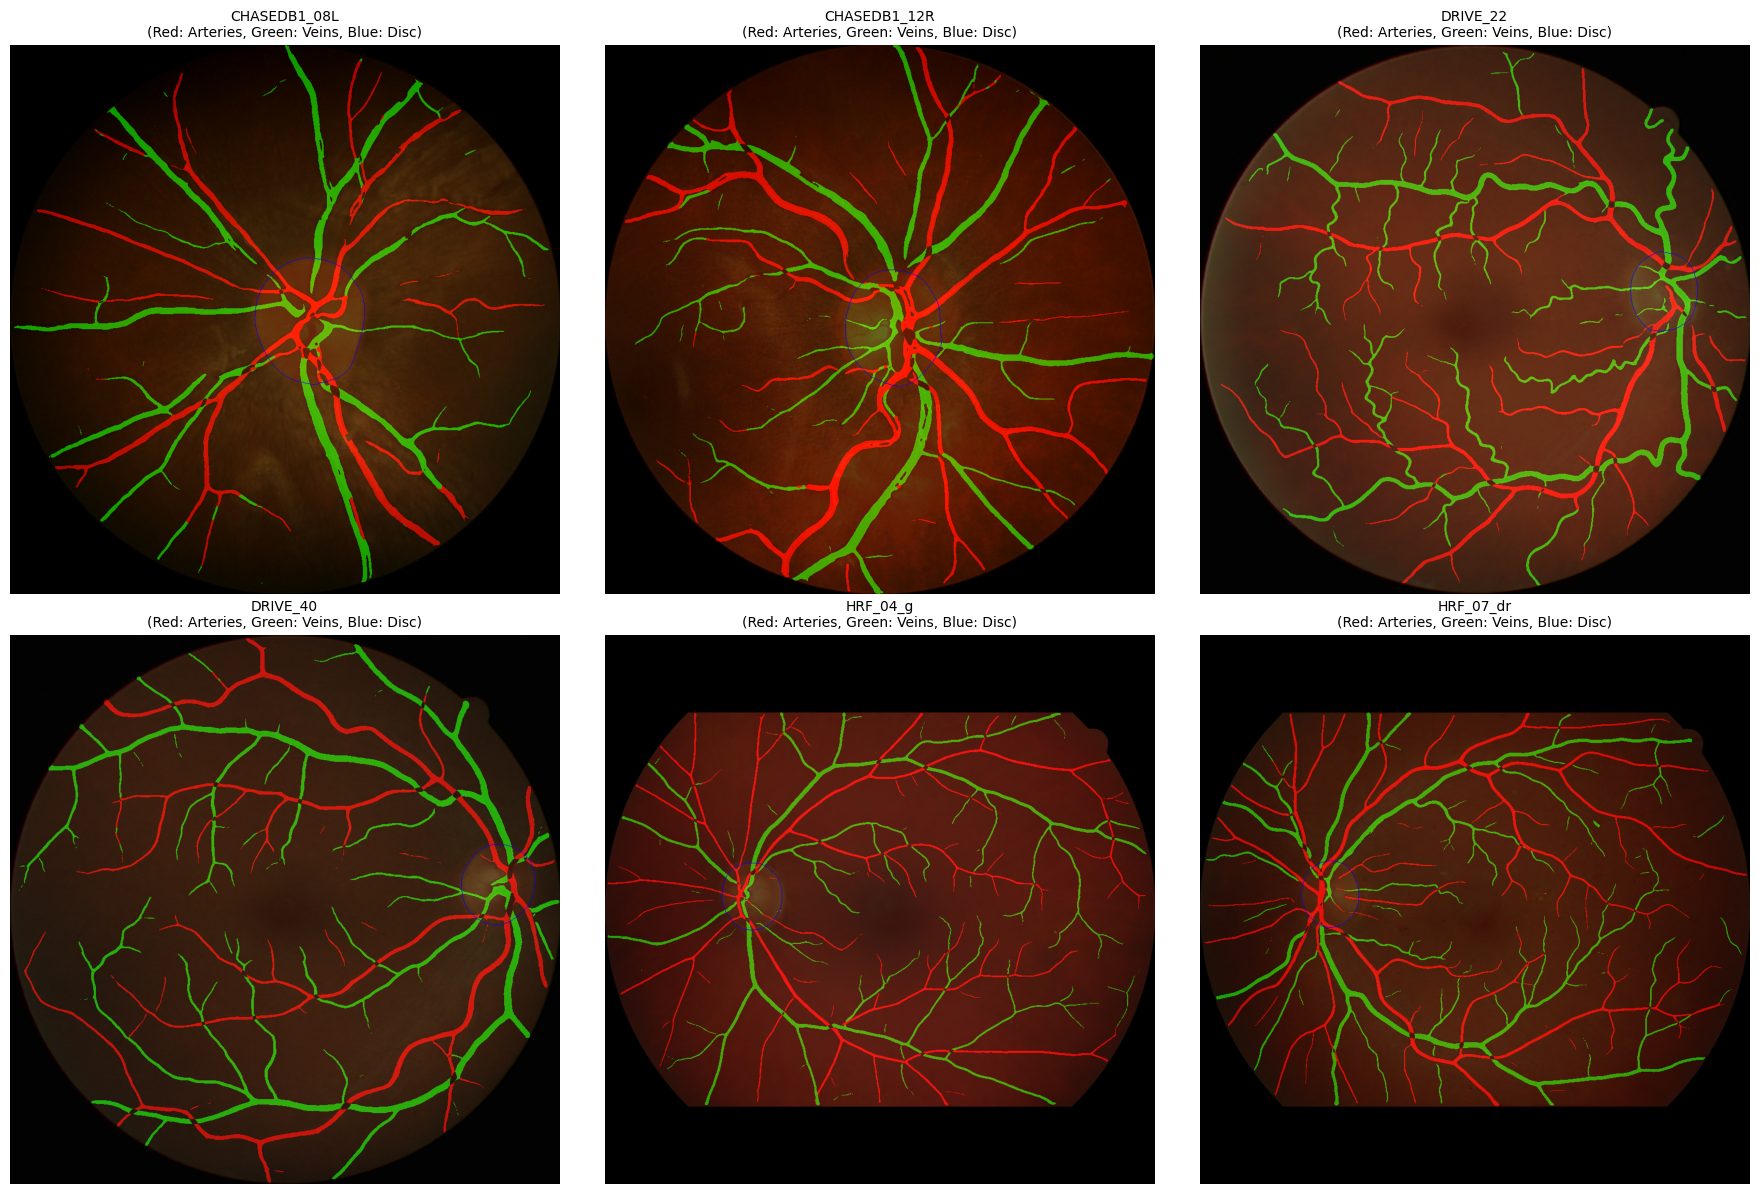

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_segmentation_results():
    """Plot a grid of segmentation results with separate artery and vein masks."""
    # Get the first 6 images
    sample_rgb_paths = rgb_paths[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, rgb_path in enumerate(sample_rgb_paths):
        if i >= 6:
            break
            
        image_id = rgb_path.stem
        
        # Load original image
        rgb_image = np.array(Image.open(rgb_path))
        
        # Create a colored overlay combining arteries and veins
        artery_path_img = arteries_path / f"{image_id}.png"
        vein_path_img = veins_path / f"{image_id}.png"
        
        if artery_path_img.exists() and vein_path_img.exists():
            artery_mask = np.array(Image.open(artery_path_img)) > 0  # Binary mask
            vein_mask = np.array(Image.open(vein_path_img)) > 0  # Binary mask
            
            # Create RGB overlay
            overlay = np.zeros_like(rgb_image)
            overlay[artery_mask] = [255, 0, 0]  # Arteries in red
            overlay[vein_mask] = [0, 255, 0]    # Veins in green
            
            # Blend overlay with original image
            alpha = 0.6
            result = (1 - alpha) * rgb_image + alpha * overlay
            result = np.clip(result, 0, 255).astype(np.uint8)
            
            # Add disc contour if available
            disc_path_img = discs_path / f"{image_id}.png"
            if disc_path_img.exists():
                disc_mask = np.array(Image.open(disc_path_img)) > 0
                # Draw disc contour in blue
                from scipy import ndimage
                disc_contour = ndimage.binary_erosion(disc_mask) != disc_mask
                result[disc_contour] = [0, 0, 255]
        else:
            result = rgb_image
        
        axes[i].imshow(result)
        axes[i].set_title(f"{image_id}\n(Red: Arteries, Green: Veins, Blue: Disc)", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Generating visualization of segmentation results...")
plot_segmentation_results()

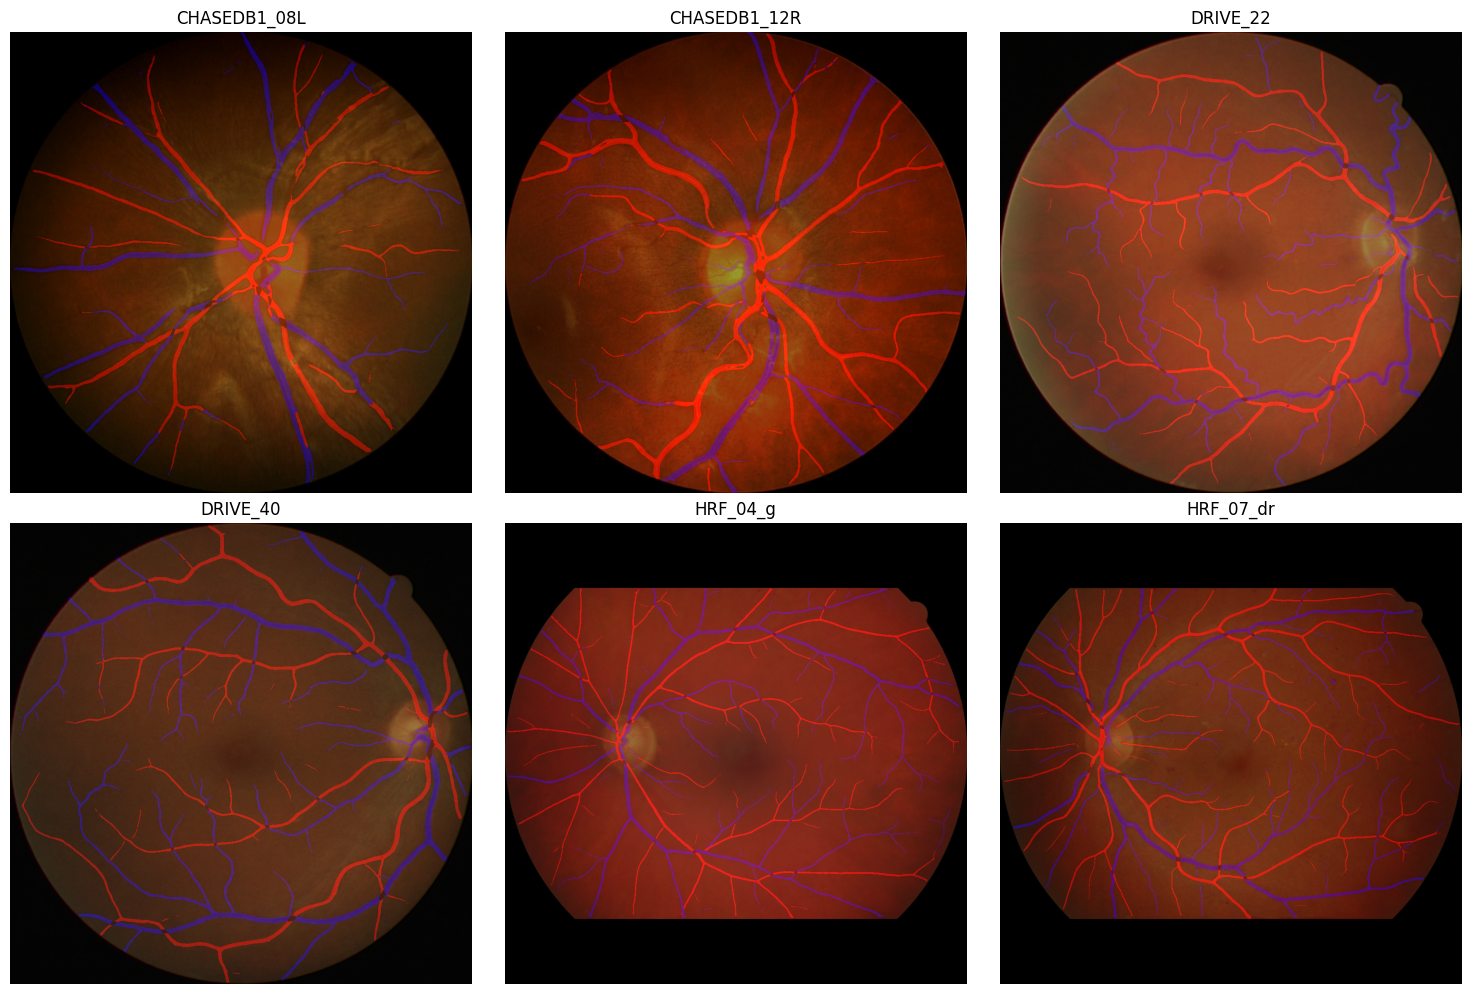

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_segmentation_results():
    """Plot a grid of segmentation results."""
    # Get the first 6 images
    sample_rgb_paths = rgb_paths[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, rgb_path in enumerate(sample_rgb_paths):
        if i >= 6:
            break
            
        image_id = rgb_path.stem
        
        # Load original image
        rgb_image = np.array(Image.open(rgb_path))
        
        # Load AV segmentation if available
        av_path_img = av_path / f"{image_id}.png"
        if av_path_img.exists():
            av_mask = np.array(Image.open(av_path_img))
            # Create a simple overlay where AV classes are colored differently
            overlay = np.zeros_like(rgb_image)
            overlay[av_mask == 1] = [255, 0, 0]  # Arteries in red
            overlay[av_mask == 2] = [0, 0, 255]  # Veins in blue
            # Blend overlay with original image
            alpha = 0.4
            result = (1 - alpha) * rgb_image + alpha * overlay
        else:
            result = rgb_image
        
        axes[i].imshow(result.astype(np.uint8))
        axes[i].set_title(f"{image_id}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_segmentation_results()

### Storing visualizations (optional)


In [ ]:
# Create overlay visualizations for all images
print("Creating overlay visualizations for all images...")

if not overlays_path.exists():
    overlays_path.mkdir(exist_ok=True, parents=True)

from scipy import ndimage

for rgb_path in rgb_paths:
    image_id = rgb_path.stem
    
    # Load original image
    rgb_image = np.array(Image.open(rgb_path))
    
    # Check if segmentation masks exist
    artery_path_img = arteries_path / f"{image_id}.png"
    vein_path_img = veins_path / f"{image_id}.png"
    disc_path_img = discs_path / f"{image_id}.png"
    
    if artery_path_img.exists() and vein_path_img.exists():
        # Create overlay
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original RGB image
        axes[0].imshow(rgb_image)
        axes[0].set_title(f"Original: {image_id}")
        axes[0].axis('off')
        
        # Artery mask
        artery_mask = np.array(Image.open(artery_path_img))
        axes[1].imshow(artery_mask, cmap='Reds')
        axes[1].set_title("Artery Mask")
        axes[1].axis('off')
        
        # Vein mask
        vein_mask = np.array(Image.open(vein_path_img))
        axes[2].imshow(vein_mask, cmap='Greens')
        axes[2].set_title("Vein Mask")
        axes[2].axis('off')
        
        # Combined overlay
        overlay = np.zeros_like(rgb_image)
        overlay[artery_mask > 0] = [255, 0, 0]  # Arteries in red
        overlay[vein_mask > 0] = [0, 255, 0]    # Veins in green
        
        # Add disc if available
        if disc_path_img.exists():
            disc_mask = np.array(Image.open(disc_path_img)) > 0
            try:
                disc_contour = ndimage.binary_erosion(disc_mask) != disc_mask
                overlay[disc_contour] = [0, 0, 255]  # Disc contour in blue
            except:
                # If scipy fails, just skip the disc contour
                pass
        
        # Blend with original
        alpha = 0.6
        combined = (1 - alpha) * rgb_image + alpha * overlay
        combined = np.clip(combined, 0, 255).astype(np.uint8)
        
        axes[3].imshow(combined)
        axes[3].set_title("Combined Overlay")
        axes[3].axis('off')
        
        plt.tight_layout()
        
        # Save overlay
        overlay_file = overlays_path / f"{image_id}.png"
        plt.savefig(overlay_file, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close()
        
        print(f"Created overlay for {image_id}")
    else:
        print(f"Skipping {image_id} - segmentation masks not found")

print(f"\nOverlay creation complete. Files saved to: {overlays_path}")

# Summary of created files
print("=" * 60)
print("SEGMENTATION SUMMARY")
print("=" * 60)

# Count files in each directory
n_rgb = len(rgb_paths)
n_arteries = len(list(arteries_path.glob("*.png"))) if arteries_path.exists() else 0
n_veins = len(list(veins_path.glob("*.png"))) if veins_path.exists() else 0
n_discs = len(list(discs_path.glob("*.png"))) if discs_path.exists() else 0
n_overlays = len(list(overlays_path.glob("*.png"))) if overlays_path.exists() else 0

print(f"Original RGB images: {n_rgb}")
print(f"Artery binary masks: {n_arteries}")
print(f"Vein binary masks: {n_veins}")
print(f"Disc binary masks: {n_discs}")
print(f"Overlay visualizations: {n_overlays}")

print("\nOutput folders:")
print(f"  - Arteries: {arteries_path}")
print(f"  - Veins: {veins_path}")
print(f"  - Discs: {discs_path}")
print(f"  - Overlays: {overlays_path}")

# Check fovea detection
fovea_csv = ds_path / "fovea.csv"
if fovea_csv.exists():
    fovea_data = pd.read_csv(fovea_csv, index_col=0)
    print(f"Fovea detections: {len(fovea_data)}")
    print(f"  - Fovea CSV: {fovea_csv}")

print("\nFile format:")
print("  - Artery masks: Binary PNG (0=background, 255=artery)")
print("  - Vein masks: Binary PNG (0=background, 255=vein)")
print("  - Disc masks: Binary PNG (0=background, 255=disc)")
print("  - Overlays: RGB PNG with colored segmentations")

Creating overlay visualizations for all images...
Created overlay for CHASEDB1_08L
Created overlay for CHASEDB1_12R
Created overlay for DRIVE_22
Created overlay for DRIVE_40
Created overlay for HRF_04_g
Created overlay for HRF_07_dr

Overlay creation complete. Files saved to: ../samples/fundus/overlays
SEGMENTATION SUMMARY
Original RGB images: 6
Artery binary masks: 6
Vein binary masks: 6
Disc binary masks: 6
Overlay visualizations: 6

Output folders:
  - Arteries: ../samples/fundus/arteries
  - Veins: ../samples/fundus/veins
  - Discs: ../samples/fundus/discs
  - Overlays: ../samples/fundus/overlays


NameError: name 'pd' is not defined